# Python e OpenCV

---

Entrega realizada para a matéria de Disruptibe Architectures IOT e IA.
Alunos: 
*   RM 85542 - Giovanna Caroline Adorno
*   RM 83448 - Gustavo Malvone

Turma: 2TDSA

## Segmentando imagens

Inicialmente, utilizamos a técnica de segmentação por cores, é separado da imagem apenas as figuras com cor vermelha ou ciano, usando a função inRange do open cv.

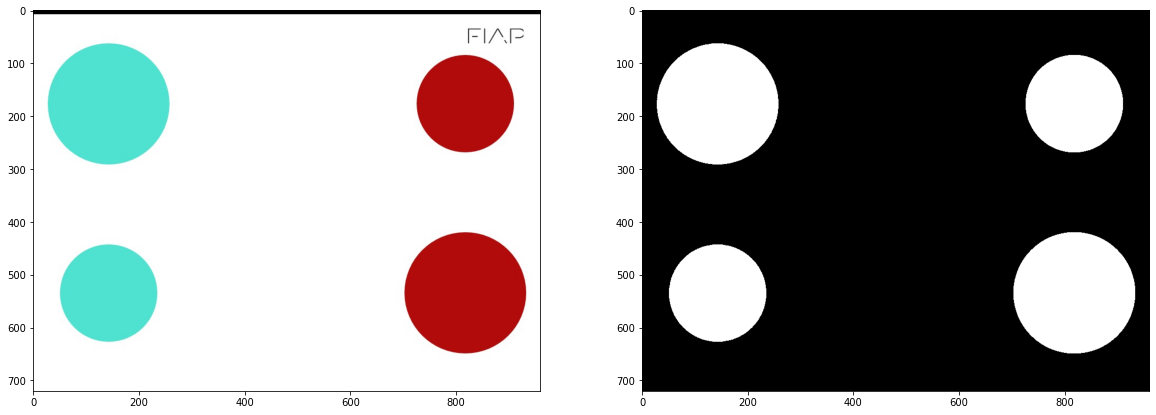

In [76]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('circulos.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#PRIMEIRO RANGE DE VERMELHO
image_lower_hsv_red1 = np.array([160, 50, 50])  
image_upper_hsv_red1 = np.array([180, 255, 255])
mask_hsv1 = cv2.inRange(img_hsv, image_lower_hsv_red1, image_upper_hsv_red1)

#SEGUNDO RANGE DE VERMELHO
image_lower_hsv_red2 = np.array([0, 50, 50])  
image_upper_hsv_red2 = np.array([10, 255, 255])
mask_hsv2 = cv2.inRange(img_hsv, image_lower_hsv_red2, image_upper_hsv_red2)

#CIANO
image_lower_hsv_ciano = np.array([80, 50, 50])
image_upper_hsv_ciano = np.array([100, 240, 240])
mask_hsv3 = cv2.inRange(img_hsv, image_lower_hsv_ciano, image_upper_hsv_ciano)

saida = cv2.bitwise_or(mask_hsv1,mask_hsv2)
saida = cv2.bitwise_or(saida, mask_hsv3)

fig = plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.subplot(2, 2, 2)
plt.imshow(saida, cmap="gray", vmin=0, vmax=255)
plt.show()

## Adicionando contorno

No bloco de código a seguir, iremos buscar os contornos das figuras anteriormente selecionadas por cor, e realizar uma lógica para identificar os contornos apenas das 2 maiores figuras.

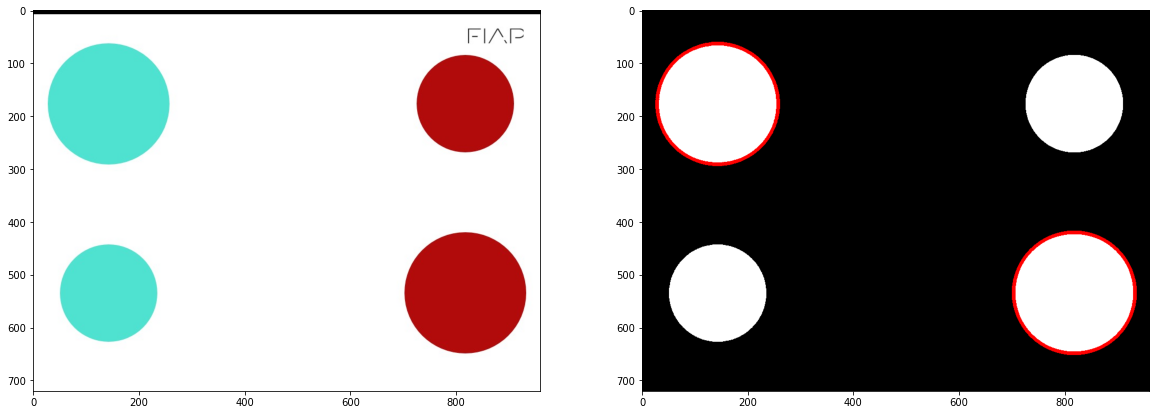

In [77]:
contornos, _ = cv2.findContours(saida, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

mask_rgb = cv2.cvtColor(saida, cv2.COLOR_GRAY2RGB) 
contornos_img = mask_rgb.copy() # Cópia da máscara para ser desenhada "por cima"

maior = None
maior_area = 0
segunda_maior = None
segunda_maior_area = 0

for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
      if maior_area > segunda_maior_area:
        segunda_maior_area = maior_area
        segunda_maior = maior
      maior_area = area
      maior = c
    elif area > segunda_maior_area:
      segunda_maior_area = area
      segunda_maior = c

cv2.drawContours(contornos_img, [maior], -1, [255, 0, 0], 5);
cv2.drawContours(contornos_img, [segunda_maior], -1, [255, 0, 0], 5);

fig = plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.subplot(2, 2, 2)

plt.imshow(contornos_img)

## Área e Centro de Massa

Com os contornos já realizados, é necessário descobrir o centro de massa, isso será feito descobrindo as coordenadas dos centros pela função moments do cv2. Com essas coordenadas, exibimos o valor das mesmas na altura de seu respectivo círculo, juntamente com o valor das massas.

Logo após é desenhado duas linhas para formar um sinal de + que indica o centro de massa da figura, isso é feito utilizando a função line do open cv.

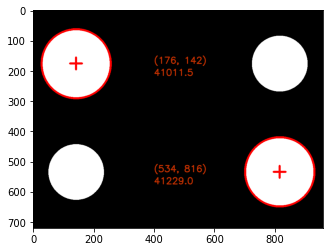

In [78]:

moments_maior = cv2.moments(maior)
cx_maior = int(moments_maior['m10']/moments_maior['m00'])
cy_maior = int(moments_maior['m01']/moments_maior['m00'])

moments_segunda_maior = cv2.moments(segunda_maior)
cx_segunda_maior = int(moments_segunda_maior['m10']/moments_segunda_maior['m00'])
cy_segunda_maior = int(moments_segunda_maior['m01']/moments_segunda_maior['m00'])

centros_img = contornos_img.copy()

font = cv2.FONT_HERSHEY_SIMPLEX
text = cy_maior , cx_maior
origem = (400, cy_maior)

cv2.putText(centros_img, str(text), origem, font,1,(200,50,0),2,cv2.LINE_AA)

text = segunda_maior_area
origem = (400, cy_segunda_maior+ 40)

cv2.putText(centros_img, str(text), origem, font,1,(200,50,0),2,cv2.LINE_AA)

text = cy_segunda_maior , cx_segunda_maior
origem = (400, cy_segunda_maior)

cv2.putText(centros_img, str(text), origem, font,1,(200,50,0),2,cv2.LINE_AA)

text = maior_area
origem = (400, cy_maior+ 40)

cv2.putText(centros_img, str(text), origem, font,1,(200,50,0),2,cv2.LINE_AA)

size = 20
color = (255,0,0)

cv2.line(centros_img,(cx_maior - size,cy_maior),(cx_maior + size, cy_maior),color,5)
cv2.line(centros_img,(cx_maior,cy_maior - size),(cx_maior, cy_maior + size),color,5)

cv2.line(centros_img,(cx_segunda_maior - size,cy_segunda_maior),(cx_segunda_maior + size, cy_segunda_maior),color,5)
cv2.line(centros_img,(cx_segunda_maior,cy_segunda_maior - size),(cx_segunda_maior, cy_segunda_maior + size),color,5)

plt.imshow(centros_img);


## Linha entre centros de figuras
Agora, juntaremos as coordenadas de centro dos dois círculos, formando uma reta entre eles.

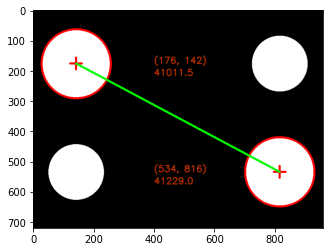

In [79]:
line_img = centros_img.copy()

cv2.line(line_img, (cx_maior, cy_maior), (cx_segunda_maior, cy_segunda_maior), (0, 255, 0), 5)

plt.imshow(line_img);

#Formação de Ângulo
Para ajudar na visualização do angulo formado em relação a um eixo x, é desenhado uma reta para simboliza-lo.

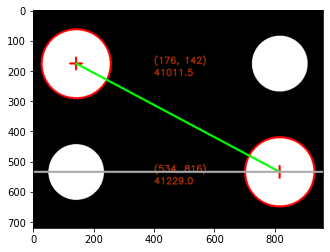

In [80]:
reta_img = line_img.copy()

cv2.line(reta_img, (0, cy_maior), (reta_img.shape[1], cy_maior), (171, 171, 171), 5)

plt.imshow(reta_img);

## Valor do Ângulo Interno
Agora, com o angulo visível, é feito o calculo do angulo utilizando a função atan2 do package math.
Depois ele é convertido em graus e exibido na parte inferior da imagem.

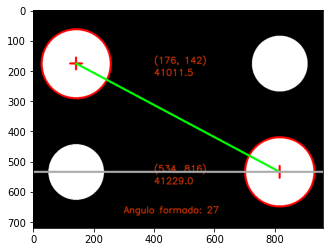

In [81]:
import math

angulo_img = reta_img.copy()

altura_y = cy_maior - cy_segunda_maior
largura_x = cx_maior - cx_segunda_maior

angulo = math.atan2(altura_y, largura_x)

graus = math.degrees(angulo)

text = 'Angulo formado: ' + str(int(graus))
origem = (300, contornos_img.shape[0] - 50)

cv2.putText(angulo_img, str(text), origem, font,1,(200,50,0),2,cv2.LINE_AA)

plt.imshow(angulo_img);